In [1]:
import logging
import threading
import itertools
import json

import pandas as pd
from pandas.plotting import register_matplotlib_converters
import numpy as np  
import scipy as sp
import ruptures as rpt

from sklearn import cluster, datasets, mixture
from sklearn import ensemble
from sklearn import linear_model
from sklearn import metrics
from sklearn import covariance
from sklearn.neighbors import (KernelDensity, NearestNeighbors, kneighbors_graph)
from sklearn.pipeline import Pipeline, TransformerMixin
from sklearn.model_selection import train_test_split
from sklearn.mixture import BayesianGaussianMixture
from sklearn.preprocessing import (StandardScaler, RobustScaler, MinMaxScaler,
                                   minmax_scale, PolynomialFeatures)
from sklearn.utils import check_array

import skimage as ski
from skimage import util as skiutil

from pandas_profiling import ProfileReport

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
register_matplotlib_converters()

In [2]:
from ipywidgets import widgets
from IPython.display import display
text = widgets.Text()
display(text)
text.on_submit('hello')

Text(value='')

In [3]:
#df_raw = pd.read_csv('./data/R_WSBYMBROW000032_20220524_094809.csv')
df_raw = pd.read_csv('./data/R_WSBYMBROW000032_20220524_094809 (2).csv', 
                     parse_dates=['TimeStamp'], infer_datetime_format=True).dropna(subset=['Cycle Number'])
#df_raw['Program Line Number'] = df_raw['Program Line Number'].values.astype(str)

df_raw = df_raw.astype({'Cycle Number':'string'})

In [4]:
cond = df_raw['Program Line Number'] != 0
cycle_idx = np.where(cond.values[:-1] != cond.values[1:])[0]  #odd start of cycle, even end of cycle

# length of each cycle (even - odd)
#cycle_idx[1::2] - cycle_idx[::2]
# starting point of each cycle in the full data frame (odd)
#cycle_idx[::2]
# starting point of each cycle but the first (index 0)
#np.cumsum(cycle_idx[1::2] - cycle_idx[::2])
idx_cycle = np.insert(np.cumsum(cycle_idx[1::2] - cycle_idx[::2]), 0, 0)

In [5]:
df_1 = df_raw[df_raw['Program Line Number'] != 0].dropna(subset=['Cycle Number'])


### Excluded profile in order not to give away source of the data

In [242]:
'''
profile = ProfileReport(df_1, title="Robot profiling report")
profile.to_widgets()
'''

'\nprofile = ProfileReport(df_1, title="Robot profiling report")\nprofile.to_widgets()\n'

In [7]:
from sqlalchemy import Column, Integer, String, Float, DateTime, Boolean, func
from iotfunctions import base
from iotfunctions import bif
from iotfunctions import entity
from iotfunctions import metadata
from iotfunctions.metadata import EntityType
from iotfunctions.db import Database
from iotfunctions.dbtables import FileModelStore
from iotfunctions.enginelog import EngineLogging
from iotfunctions import estimator
from iotfunctions.bif import PythonExpression
from iotfunctions.ui import (UISingle, UIMultiItem, UIFunctionOutSingle,
                 UISingleItem, UIFunctionOutMulti, UIMulti, UIExpression,
                 UIText, UIStatusFlag, UIParameters)
from iotfunctions.anomaly import (SaliencybasedGeneralizedAnomalyScore, SpectralAnomalyScore,
                 FFTbasedGeneralizedAnomalyScore, KMeansAnomalyScore, NoDataAnomalyScore,
                 SaliencybasedGeneralizedAnomalyScoreV2, FFTbasedGeneralizedAnomalyScoreV2, 
                 KMeansAnomalyScoreV2, BayesRidgeRegressor, RobustThreshold)
from mmfunctions.anomaly import (FeatureBuilder, GBMForecaster, KDEAnomalyScore1d,
                                 VIAnomalyScore, SpectralAnomalyScoreExt, MatrixProfileAnomalyScore,
                                 NoDataAnomalyScoreExt, ChangePointDetector, EnsembleAnomalyScore,
                                 GMMAnomalyScore)

2022-06-23 01:06:25.605957: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-06-23 01:06:25.605977: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-06-23 01:06:27.026018: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-23 01:06:27.026663: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-06-23 01:06:27.026790: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.s

In [8]:
df_1.columns

Index(['SNo', 'Current J1', 'Position J1', 'Current J2', 'Position J2',
       'Current J3', 'Position J3', 'Current J4', 'Position J4', 'Current J5',
       'Position J5', 'Current J6', 'Position J6', 'Cycle Number',
       'Program Register', 'Program Name', 'Program Line Number',
       'Robot Fault Output', 'Alarm', 'Battery Low Level Output', 'Date',
       'TimeStamp', 'Quality'],
      dtype='object')

In [9]:
from datetime import datetime, timedelta
stamps = np.unique(df_1['TimeStamp'])
for stamp in stamps:
    cond = df_1['TimeStamp'] == stamp
    #ix = np.min(np.nonzero(cond.values))
    ix = df_1.index[np.nonzero(cond.values)]
    #df_t = df_1.loc[df_1['TimeStamp'] == stamp]
    t = pd.date_range(start=df_1.loc[ix[0]]['TimeStamp'],
                      end=df_1.loc[ix[0]]['TimeStamp'] + np.timedelta64(1,'s'),
                      periods=np.count_nonzero(cond))
    #for ix1,t1 in zip(np.nonzero(cond.values),t):
    df_1.loc[ix, 'TimeStamp'] = t


In [10]:
df_1['Cycle Number'] != 'nan'

10098     True
10099     True
10100     True
10101     True
10102     True
          ... 
673190    True
673191    True
673192    True
673193    True
673194    True
Name: Cycle Number, Length: 210913, dtype: boolean

In [11]:
df_i = df_1.set_index(['Cycle Number','TimeStamp'])

In [12]:
db_schema=None
class DatabaseDummy:
    tenant_id = '###_IBM_###'
    db_type = 'db2'
    model_store = FileModelStore()
    def _init(self):
        return

db = DatabaseDummy()
        
print (db.tenant_id)

###_IBM_###


In [13]:
Temperature = 'Current J1'
spectral = Temperature + '_spectral'
spectralinv = Temperature + '_spectralinv'
kmeans = Temperature + '_kmeans'
kde = Temperature + '_kde'

In [14]:
jobsettings = { 'db': db, 
               '_db_schema': 'public', 'save_trace_to_file' : True}

gmmi = SpectralAnomalyScoreExt(Temperature, 12, spectral, spectralinv)
et = gmmi._build_entity_type(columns = [Column(Temperature,Float())], **jobsettings)
gmmi._entity_type = et
df_i = gmmi.execute(df=df_i)

In [15]:
jobsettings = { 'db': db, 
               '_db_schema': 'public', 'save_trace_to_file' : True}

kmmi = KMeansAnomalyScore(Temperature, 12, kmeans)
et = kmmi._build_entity_type(columns = [Column(Temperature,Float())], **jobsettings)
kmmi._entity_type = et
df_i = kmmi.execute(df=df_i)

In [16]:
jobsettings = { 'db': db, 
               '_db_schema': 'public', 'save_trace_to_file' : True}

kdei = KDEAnomalyScore1d(Temperature, 12, kde)
et = kdei._build_entity_type(columns = [Column(Temperature,Float())], **jobsettings)
kdei._entity_type = et
df_i = kdei.execute(df=df_i)

(279, 1) (279, 1) (279, 1)
(1183, 1) (1183, 1) (1183, 1)
(277, 1) (277, 1) (277, 1)
(1240, 1) (1240, 1) (1240, 1)
(278, 1) (278, 1) (278, 1)
(1185, 1) (1185, 1) (1185, 1)
(277, 1) (277, 1) (277, 1)
(278, 1) (278, 1) (278, 1)
(275, 1) (275, 1) (275, 1)
(277, 1) (277, 1) (277, 1)
(276, 1) (276, 1) (276, 1)
(1240, 1) (1240, 1) (1240, 1)
(1183, 1) (1183, 1) (1183, 1)
(277, 1) (277, 1) (277, 1)
(278, 1) (278, 1) (278, 1)
(1185, 1) (1185, 1) (1185, 1)
(279, 1) (279, 1) (279, 1)
(278, 1) (278, 1) (278, 1)
(279, 1) (279, 1) (279, 1)
(400, 1) (400, 1) (400, 1)
(976, 1) (976, 1) (976, 1)
(970, 1) (970, 1) (970, 1)
(965, 1) (965, 1) (965, 1)
(975, 1) (975, 1) (975, 1)
(890, 1) (890, 1) (890, 1)
(335, 1) (335, 1) (335, 1)
(974, 1) (974, 1) (974, 1)
(971, 1) (971, 1) (971, 1)
(975, 1) (975, 1) (975, 1)
(971, 1) (971, 1) (971, 1)
(974, 1) (974, 1) (974, 1)
(531, 1) (531, 1) (531, 1)
(977, 1) (977, 1) (977, 1)
(975, 1) (975, 1) (975, 1)
(977, 1) (977, 1) (977, 1)
(964, 1) (964, 1) (964, 1)
(759, 1) (

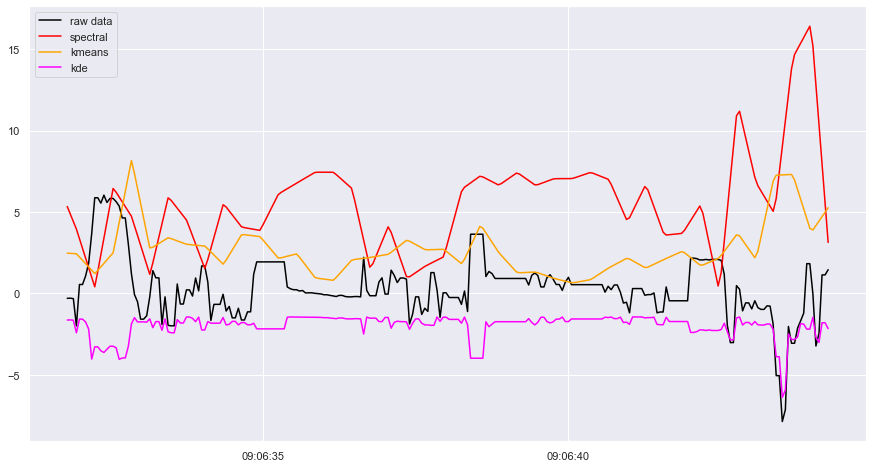

In [17]:
myrange = slice(300,550)
df_loc = df_i.reset_index().set_index('TimeStamp')
fig, ax = plt.subplots(1,1,figsize=(15,8))
ax.plot(df_loc.index[myrange], df_loc[Temperature][myrange], c='black', label='raw data')
ax.plot(df_loc.index[myrange], df_loc[spectral][myrange]/3, color='red', label='spectral')
ax.plot(df_loc.index[myrange], df_loc[kmeans][myrange], color='orange', label='kmeans')
ax.plot(df_loc.index[myrange], df_loc[kde][myrange], color='magenta', label='kde')

ax.legend()


### Distribution of data per cycle

231
WSBYMBROW000032_41_20220524_15:10:27 <class 'str'>


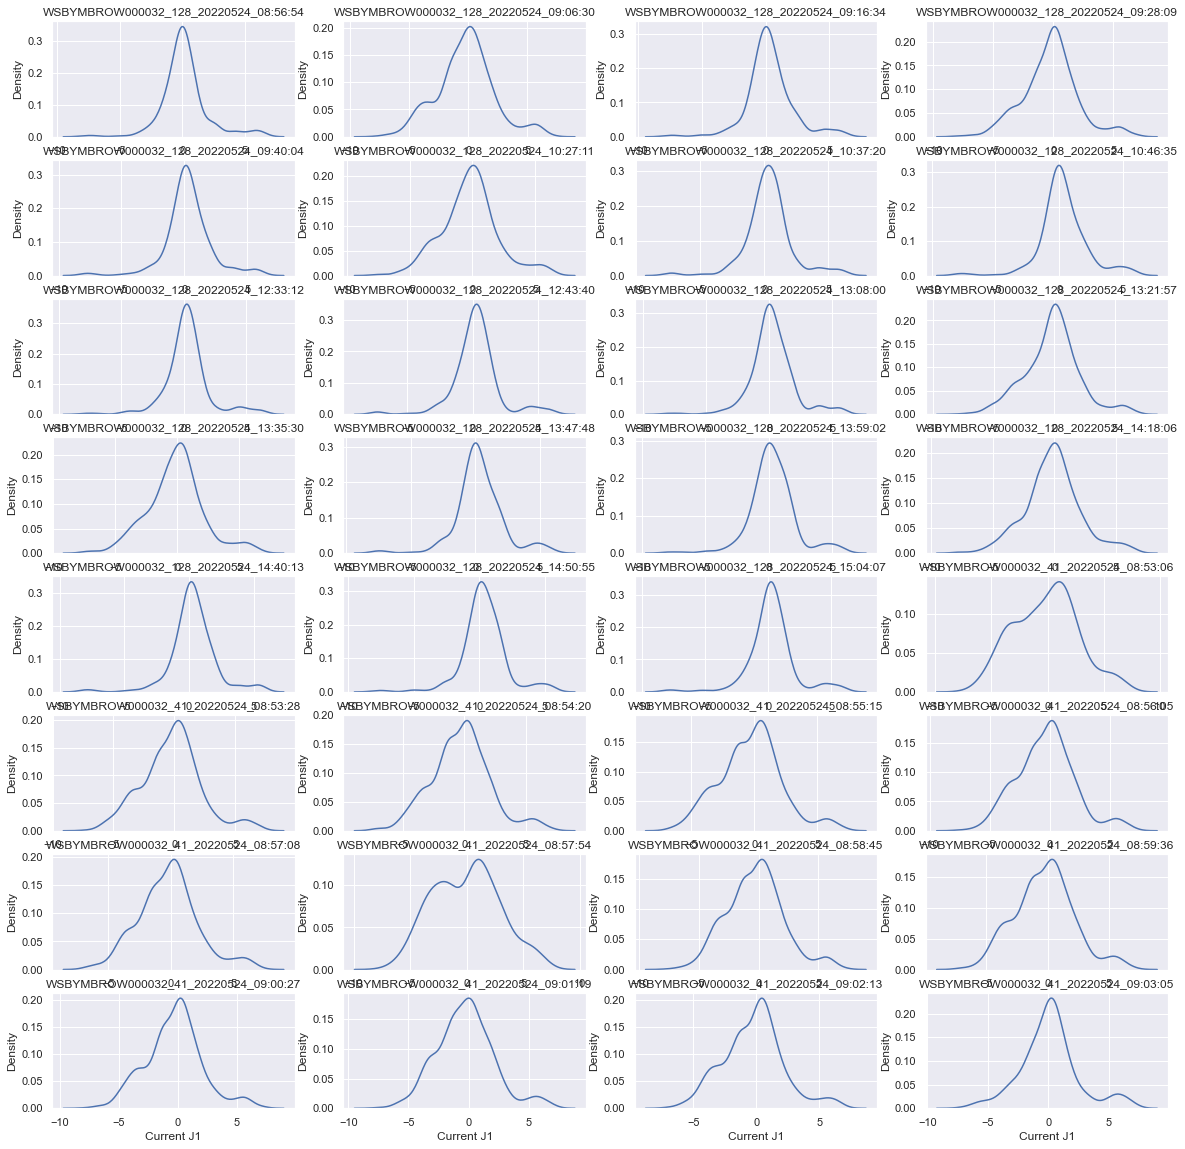

In [22]:
df_ii = df_i.reset_index()
#g = sns.FacetGrid(df_1, row='Cycle Number', col='SNo')
cycles = np.unique(df_ii['Cycle Number'].values)
plots = cycles.shape[0]
print(plots)
starter = 0
length = 32
myrange = slice(starter,starter+length)
print(cycles[230], type(cycles[230]))

fig, ax = plt.subplots(int(length/4), 4, figsize=(20, 20))
i = 0
j = 0
for cycle in cycles[myrange]:
    ax[i][j].set_title(cycle)
    sns.kdeplot(df_i.loc[cycle]['Current J1'], ax=ax[i][j])
    j+=1
    if j > 3:
        j=0
        i+=1

In [228]:
# don't do it - it's 230 different plots !~~
'''
# Distributions
g = sns.FacetGrid(pd.melt(df_1.reset_index(),
                      id_vars=['Cycle Number'],
                      value_vars=['Current J1']), hue='Cycle Number', col='Cycle Number', col_wrap=5,
                  height=10, aspect=1)
             # hue='Cycle Number',row='variable') # ,col='id2', row='variable'
    
g.map(sns.kdeplot,'value')
'''

"\n# Distributions\ng = sns.FacetGrid(pd.melt(df_1.reset_index(),\n                      id_vars=['Cycle Number'],\n                      value_vars=['Current J1']), hue='Cycle Number', col='Cycle Number', col_wrap=5,\n                  height=10, aspect=1)\n             # hue='Cycle Number',row='variable') # ,col='id2', row='variable'\n    \ng.map(sns.kdeplot,'value')\n"

### KL divergence approach

Use the first 10 cycles to train - and then compare the rest by computing the divergence **from** the training data distribution **to** the new cycles.
(to get a large penalty if we see data with a probability of close to 0 w.r.t the original data)

Follow "Kullback-Leibler Divergence Estimation of Continuous Distributions" from Fernando Perez-Cruz to address the different cardinalities of the sample sets representing the 2 distributions to compare.


https://www.tsc.uc3m.es/~fernando/bare_conf3.pdf

Compute KL from the epsilon differences to the ECDF following Tiago Rosa dos Reis
https://gist.github.com/tdosreis/9fa0ac693bb0805b70e4b20d612ab81a#file-cumulative_divergence-py


In [241]:
from statsmodels.distributions.empirical_distribution import ECDF

# Approximate ECDF with piecewise linear function
def lin_ecdf(x): 
    x = np.sort(x)
    u, c = np.unique(x, return_counts=True)
    n = len(x)
    y = (np.cumsum(c) - 0.5)/n
    def interpolate_(x_):
        yinterp = np.interp(x_, u, y, left=0.0, right=1.0)
        return yinterp
    return interpolate_


def cumulative_kl(x,y,fraction=0.2):
    # smallest difference > 0
    x_sort = np.sort(np.unique(x))
    y_sort = np.sort(np.unique(y))
    dx = np.diff(x_sort)
    dy = np.diff(y_sort)
    ex = np.min(dx)
    ey = np.min(dy)
    e = np.min([ex,ey])*fraction
    
    # normalizer
    n = len(x)
    
    # piecewise linear function to approximate ECDF
    P = lin_ecdf(x)
    Q = lin_ecdf(y)
    
    # grid to evaluate the linECDF ratio on the union of the support of Q and P
    #lower = np.min([x_sort[0], y_sort[0]])
    #higher = np.max([x_sort[-1], y_sort[-1]])
    #print(x_sort[0], y_sort[0], x_sort[-1], y_sort[-1])
    #grid = np.linspace(lower, higher, num=int(len(x) + len(y))*100)
    grid = x

    # difference
    P_g = P(grid) - P(grid-e)
    Q_g = Q(grid) - Q(grid-e)
    
    # PROBLEM: This approach avoids elements in the support of Q that are not in the support of P !!!
        
    # avoid division by zero
    frac = np.where(P_g * Q_g != 0, np.divide(P_g, Q_g, out=np.ones_like(P_g) * 10e9, where=Q_g!=0), 1)
    print(np.count_nonzero(frac > 10000))
    print(frac.shape)
    KL = (1./n)*np.sum(np.log(frac))
        #np.log((P(grid) - P(grid-e))/(Q(grid) - Q(grid-e))))
    return max(KL - 1.0,0)

print('Test it: ', cumulative_kl(df_i.loc[cycles[0]]['Current J1'], df_i.loc[cycles[2]]['Current J1']))

0
(279,)
Test it:  0.12931796105762317


**Conclusion** 

This is not what we want. Especially with a larger training set we end up with a KL divergence of zero (which is simply wrong).

### Wasserstein distance

works much better when comparing the samples from the 2 distributions to compare have different cardinality

In [196]:
sp.stats.wasserstein_distance(df_i.loc[cycles[3]]['Current J1'], df_i.loc[cycles[10]]['Current J1'])

0.6035751519401591

In [220]:
training_cycles_ = []
for i in range(0,50):
    training_cycles_.extend(df_i.loc[cycles[i]]['Current J1'].tolist())
training_cycles = np.array(training_cycles_).flatten()

In [221]:
wass_dist_ = []
for cycle in cycles:
    wass_dist_.append(sp.stats.wasserstein_distance(training_cycles, df_i.loc[cycle]['Current J1']))
wass_dist = np.array(wass_dist_)

Text(0, 0.5, 'wasserstein distance to training data')

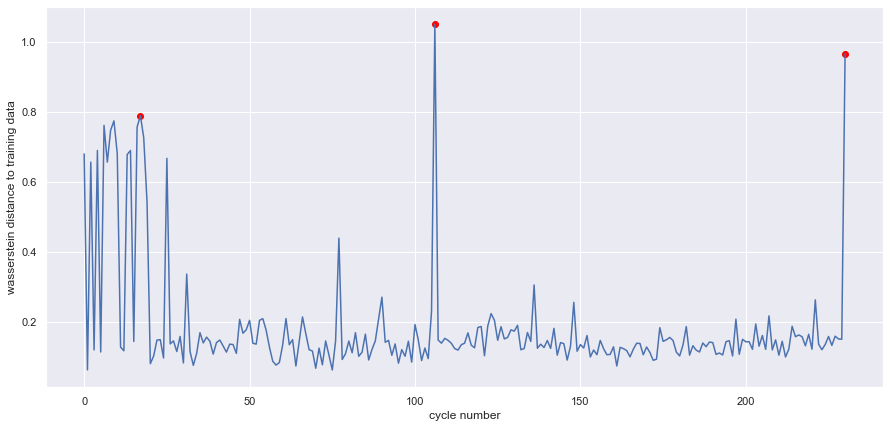

In [226]:
anom = wass_dist.copy()
anom[anom < 0.78] = np.nan
fig, ax = plt.subplots(1,1, figsize=(15,7))
ax.plot(range(len(wass_dist)), wass_dist)
ax.scatter(range(len(anom)), anom, c='red')
ax.set_xlabel('cycle number')
ax.set_ylabel('wasserstein distance to training data')



[ 17 106 230]


<AxesSubplot:title={'center':'Cycle 230'}, ylabel='Density'>

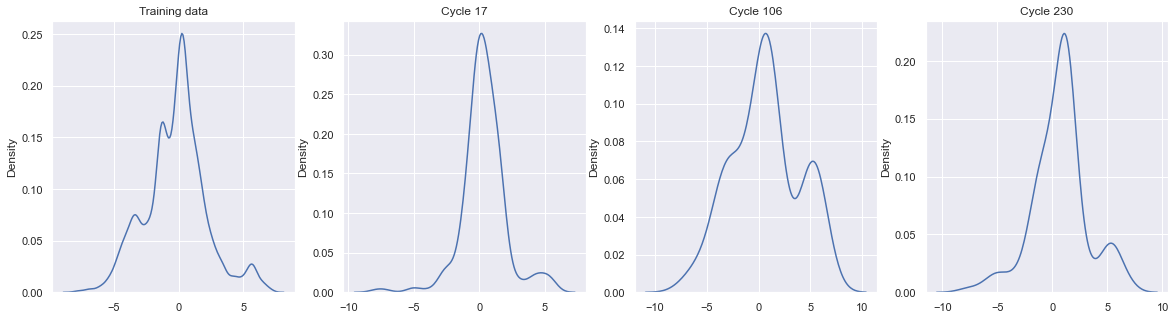

In [227]:
anoms = np.argwhere(wass_dist > 0.78).flatten()
print(anoms)

cycle25 = df_i.loc[cycles[anoms[0]]]['Current J1'].values
cycle106 = df_i.loc[cycles[anoms[1]]]['Current J1'].values
cycle230 = df_i.loc[cycles[anoms[2]]]['Current J1'].values


fig, ax = plt.subplots(1, 4, figsize=(20, 5))
ax[0].set_title('Training data')
sns.kdeplot(training_cycles, ax=ax[0])
ax[1].set_title('Cycle ' + str(anoms[0]))
sns.kdeplot(cycle25, ax=ax[1])
ax[2].set_title('Cycle ' + str(anoms[1]))
sns.kdeplot(cycle106, ax=ax[2])
ax[3].set_title('Cycle ' + str(anoms[2]))
sns.kdeplot(cycle230, ax=ax[3])


### A bit of spectral analysis

not conclusive.

Maybe we have to apply this by cycle

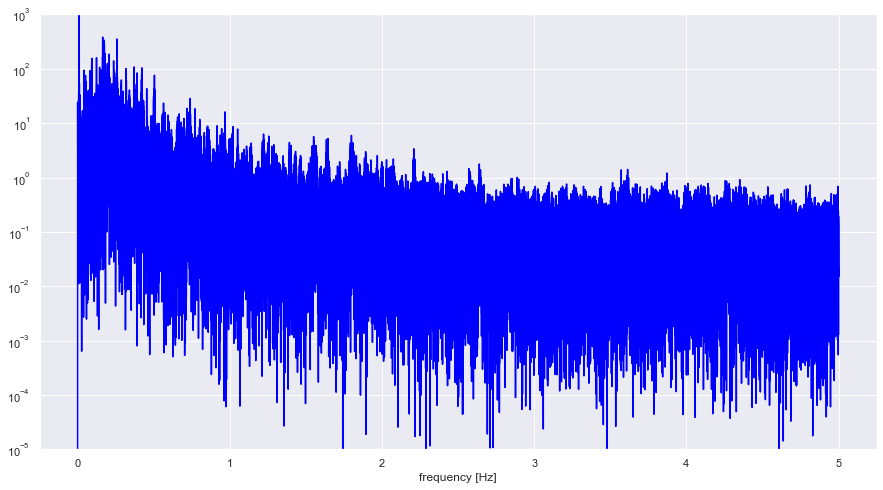

In [63]:
from matplotlib.pyplot import figure

figure(figsize=(15,8))
f, Pxx_den = sp.signal.periodogram(df_i[Temperature].values, 10)
plt.semilogy(f, Pxx_den, c='blue')
plt.ylim([1e-5, 1e3])
plt.xlabel('frequency [Hz]')

plt.show()

Text(0.5, 0, 'Time')

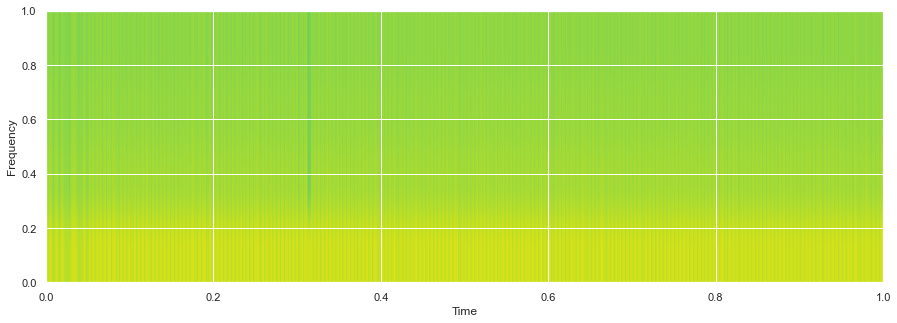

In [64]:
#temperature = df_i[Temperature].values


M=12
slices = skiutil.view_as_windows(df_i[Temperature].values, window_shape=(M,))
small = 10**(-8)

hann = np.hanning(M + 1)[:-1]
slices = slices * hann
slices = slices.T

spectrum = np.fft.fft(slices, axis=0)[:M // 2 + 1:-1]
spectrum = np.abs(spectrum)
spectrum[spectrum < small] = small
max_spec = np.max(spectrum)

fig, ax = plt.subplots(1, 1, figsize=(15,5), squeeze=False)
S = 20 * np.log10(spectrum / max_spec)
ax[0,0].imshow(S, origin='lower', cmap='viridis', extent=(0, 1, 0, 1))
ax[0,0].axis('tight')
ax[0,0].set_ylabel('Frequency')
ax[0,0].set_xlabel('Time')

#ax[0,0].plot(np.arange(temperature.shape[0]).astype(float)/4000, temperature*4-4, lw=0.8, alpha=0.3, zorder=10)

In [244]:
#take the first 3 cycles and compare

,SNo,Current J1,Position J1,Current J2,Position J2,Current J3,Position J3,Current J4,Position J4,Current J5,...,Program Register,Program Name,Program Line Number,Robot Fault Output,Alarm,Battery Low Level Output,Date,TimeStamp,Quality,entity
10098,10099,-3.78,22.06,-3.39,-40.31,4.50,0.66,-14.94,92.81,0.04,...,41,O0911_T52,110,False,NaN,False,24/05/22,2022-06-22 13:28:56.000,True,myentity
10099,10100,-3.78,22.06,-3.39,-40.31,4.50,0.66,-14.94,92.81,0.04,...,41,O0911_T52,110,False,NaN,False,24/05/22,2022-06-22 13:28:56.050,True,myentity
10100,10101,-4.05,22.06,-3.56,-40.31,4.48,0.66,-14.90,92.81,-0.10,...,41,O0911_T52,110,False,NaN,False,24/05/22,2022-06-22 13:28:56.100,True,myentity
10101,10102,-4.13,22.06,-3.75,-40.31,4.49,0.66,-15.05,92.81,-0.21,...,41,O0911_T52,110,False,NaN,False,24/05/22,2022-06-22 13:28:56.150,True,myentity
10102,10103,1.85,22.05,2.40,-40.29,2.61,0.65,1.72,92.83,1.51,...,41,O0911_T52,112,False,NaN,False,24/05/22,2022-06-22 13:28:56.200,True,myentity
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
673190,673191,1.44,-15.00,-8.72,-34.77,5.89,25.00,-0.70,0.00,0.45,...,41,O0911_T52,191,False,NaN,False,24/05/22,2022-06-22 10:21:38.800,True,myentity
673191,673192,1.25,-15.00,-8.93,-34.91,5.81,25.00,0.21,0.00,2.98,...,41,O0911_T52,191,False,NaN,False,24/05/22,2022-06-22 10:21:38.850,True,myentity
673192,673193,-3.65,-15.00,-9.04,-34.98,5.44,25.00,2.77,0.00,2.61,...,41,O0911_T52,191,False,NaN,False,24/05/22,2022-06-22 10:21:38.900,True,myentity
673193,673194,-3.65,-15.00,-9.04,-34.98,5.44,25.00,2.77,0.00,2.61,...,41,O0911_T52,191,False,NaN,False,24/05/22,2022-06-22 10:21:38.950,True,myentity


$$
\pi
$$